## Instacart - Clustering
In this notebook I will try creating customer segmentation for Instacart customers according to the purchases made.  Instacart has access to thousands of products, categorized into aisles and departments.  With the large number of features, we will look at using Principal Component Analysis to find new dimensions to make clustering easier.  

In [462]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set(style='whitegrid')

import random

In [463]:
aisles = pd.read_csv('../data/raw/aisles.csv')
orders = pd.read_csv('../data/raw/orders.csv')
products = pd.read_csv('../data/raw/products.csv')
order_details_prior = pd.read_csv('../data/raw/order_products__prior.csv')
#order_details_train = pd.read_csv('../data/raw/order_products__train.csv')

In [464]:
len(orders.user_id.unique())

206209

We have over 200,000 users in our order history.  This is just too much data for my laptop to crunch.  We will subset this to 15,005 users - 15,000 users will be used to train our model, with 5 users withheld to used for testing purposes.  The decrease in data will allow us to efficiently process data in a timely fashion. 

In [465]:
# create a set of users
unique_users = set(orders.user_id.unique())

# randomly sample 15,005 users
selected_users = random.sample(unique_users, 15005)

# reduce the orders dataset to only include data from our selected users
orders_sub = orders[orders.user_id.isin(selected_users)]

We want to join several datasets in order to achieve an overall picture of products purchased.  

We will join orders, order_details_prior, products and aisles to create our master dataset.

In [555]:
# expand products table
products_temp = pd.merge(products, aisles, on=['aisle_id'])

# expand order details table
order_details_temp = pd.merge(order_details_prior, products_temp, on=['product_id'])

In [556]:
# create full purchase history
purchase_history = pd.merge(orders_sub, order_details_temp, on=['order_id'])[['user_id', 'product_id', 'product_name', 'aisle_id', 'aisle']]

In [557]:
# how many unique aisles do we have? 
len(purchase_history.aisle.unique())

134

In [558]:
# how many unique products do we have?
len(purchase_history.product_id.unique())

38751

We want to create a frequency table to identify how many products each customer has purchased.  If we to break this table down by product, we would create a 15,000 x 38,751.  The dimensions of this matrix are just too massive to be able to crunch on my laptop.  

Another way we can analyze this data is by aggregating it by aisle.  Doing so will us a 15,000 x 134 matrix - a much more managable dataset.  In order to create this frequency table we will used the pandas crosstab function. 

In [560]:
ph_crosstab_full = pd.crosstab(index=purchase_history.user_id, columns=purchase_history.aisle)

In [561]:
# split our dataset
ph_crosstab_test = ph_crosstab_full[-5:]
ph_crosstab = ph_crosstab_full[:-5]

In [562]:
ph_crosstab.shape

(15000, 134)

In [563]:
ph_crosstab_test.shape

(5, 134)

We now have a summarized purchase history crosstab for our selected users.  Prior to performing a cluster analysis, we want to run a dimensionality reduction on the data to reduce our features from 134.

# Dimensionality Reduction
Dimensionality reduction will be completed using Principal Component Analysis (PCA).  The aim here is to reduce the number of features while retaining the greatest explained varaince as possible. 

In [103]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

We first create a PCA against all components.  This will allow us to review the explained variance and select an appropriate number of components to reduce overall dimensions.  We will also scale the data using RobustScaler.  The reason we selected RobustScaler is because our features are not normally distributed and contain many outliers.  StandardScaler is optimal for when features are normally distributed, and MinMaxScaler perfrom best without outliers.  Thus - RobustScaler. 

In [474]:
rs = RobustScaler()

ph_crosstab_scaled = rs.fit_transform(ph_crosstab)

In [475]:
# create a pca
pca_full = PCA()

# fit the data
pca_full.fit(ph_crosstab_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

With the PCA fit complete, we can investigate the results

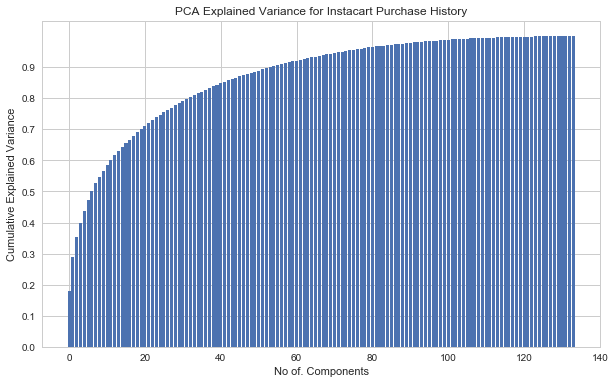

In [511]:
# Create a plot to display explained variance
y = pca_full.explained_variance_ratio_.cumsum()
x = np.arange(len(y))

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot
plt.bar(x, y)

# set labels
plt.xlabel('No of. Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance for Instacart Purchase History')
plt.yticks(np.arange(0, 1, 0.1))

fig.savefig('../reports/figures/pca_explained_variance.png')

plt.show()

In [477]:
# find cumulative sum of explained variance
ev_cumsum = pca_full.explained_variance_ratio_.cumsum()

# find out how many components we need to expain different levels of variance
for i in np.arange(0.5, 0.9, 0.05):
    print('{0:.2f}: {1:}'.format(i, np.sum(ev_cumsum <= i)))
    
for i in np.arange(0.9, 1.01, 0.01):
    print('{0:.2f}: {1:}'.format(i, np.sum(ev_cumsum <= i)))

0.50: 6
0.55: 9
0.60: 11
0.65: 15
0.70: 19
0.75: 25
0.80: 32
0.85: 41
0.90: 54
0.91: 57
0.92: 60
0.93: 64
0.94: 68
0.95: 72
0.96: 77
0.97: 84
0.98: 92
0.99: 102
1.00: 134


Examining the components, we find that we can explain 99% of the data using 102 components.  We will recreate our PCA specifying 102 components before transforming our original dataset.

In [478]:
# create a pca
pca = PCA(n_components = 102)

# fit & transform the data
ph_crosstab_t = pca.fit_transform(ph_crosstab_scaled)

In [479]:
## Saving our data
from sklearn.externals import joblib

# save our pca classifier
joblib.dump(pca, '../models/pca_aisles.pkl')

# save our crosstab_transformed
np.save('../models/ph_crosstab_t.pkl', ph_crosstab_t)

In [4]:
## Loading our Data
#from sklearn.externals import joblib

# load our pca classifier
#pca = joblib.load('../models/pca_aisles.pkl')

# load our crosstab_transformed
#ph_crosstab_t = np.load('../models/ph_crosstab_t.pkl.npy')

# Cluster Algoritms
With our PCA components identified, we begin clustering algorithms.  We will look at:
1. KMeans
2. DBScan
3. Hierarchiacal Cluster

Performance metrics for clustering algorithm will be analyzed in order to decide the appropriate number of clusters.  In particular, we will look at:

### Silhouette Coefficient
The silhouette coefficient measures how close each point in one cluster is to points in the neighboring clusters.  This score varies from -1 to 1.   measure has a range of [-1, 1].  

Scores near 1 show that the samples are far away from the neighboring clusters.  scores of 0 indicate that samples overlap or are very close to the decision boundary between enighbouring clusters.  Negative values indicate that samples might have been assigned to the wrong cluster. 

### Calinski-Harabaz Index
Calinski-Harabaz compares between-cluster dispersion to the within-cluster dispersion.  The higher the score, the more dense and well separated our clusters appear to be. 

Once an appropriate number of clusters are identified, we then will examine the top products purchased by customers in each cluster. 

In [480]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabaz_score

## 1. KMeans Clustering

KMeans is fairly straight forward - however we need to determine the appropriate amount of clusters to be used for our algorithm.  

The below function (kmeans_performance_metrics) was created for measuring kmeans performance metrics such as inertia, silhouette score and calinski-harabaz score.  It simply takes a dataset and an upper limit of k to use for clustering.  The metrics are calculated and returned.

In [481]:
def kmeans_performance_metrics(data, k):
    '''
        Compute K-Means partitions for various values of K, ranging from 
        2 to k+1.  Caclucate the inertia, silhouette score, and calinkski-harabaz
        score for each value of k, returning the results.
        
        Params
        ------
        data: The dataset to perform KMeans clustering
        
        k: The number of partitions to create
    '''
    
    # create an array to hold our results
    inertias = []
    silhouette_scores = []
    calinski_score = []
    
    # Process each range
    for i in range(2, k+1):
        print('processing k={}'.format(i))
        
        # build model
        model = KMeans(n_clusters=i, init='k-means++',random_state=42).fit(data)
        
        # determine scores
        inertias.append(model.inertia_)
        silhouette_scores.append(silhouette_score(data, model.labels_))
        calinski_score.append(calinski_harabaz_score(data, model.labels_))
    
    return inertias, silhouette_scores, calinski_score

In [482]:
# define how many clusters we want to test
clusters=15

# find the inertias related to each cluster size
inertias, silhouette_scores, calinski_score = kmeans_performance_metrics(ph_crosstab_t, clusters)

processing k=2
processing k=3
processing k=4
processing k=5
processing k=6
processing k=7
processing k=8
processing k=9
processing k=10
processing k=11
processing k=12
processing k=13
processing k=14
processing k=15


### Inertia Results

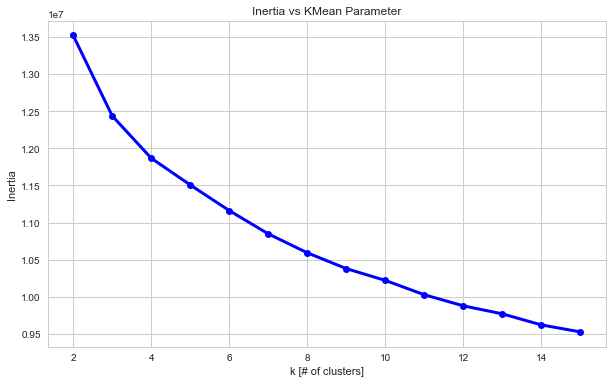

In [483]:
# Plot our results for inertia vs cluster size
fig, ax = plt.subplots(figsize=(10,6))

# plot results
plt.plot(np.arange(2, clusters+1), inertias, 'o-', color='blue', linewidth=3)

# set labels
plt.xlabel('k [# of clusters]')
plt.ylabel('Inertia')
plt.title('Inertia vs KMean Parameter')

plt.savefig('../reports/figures/kmeans_inertia.png')

plt.show()

We are trying to find a balance between K and inertia - minimizing inertia within our clusters as much as possible.  

We see a distinct elbow at k=3, however dimishing returns could be argued to occur after k=8 or k=9.  My initial thoughts are that 9 clusters seems very high for the data, though I have no prior experience with the dataset. 

If we were to simply select based on a value that minimizes k, I'd want to select k = 8.  Based on this graph alone, we cannot make a decision.  Let's move onto our other performance metrics for further analysis. 

### Silhouette Results

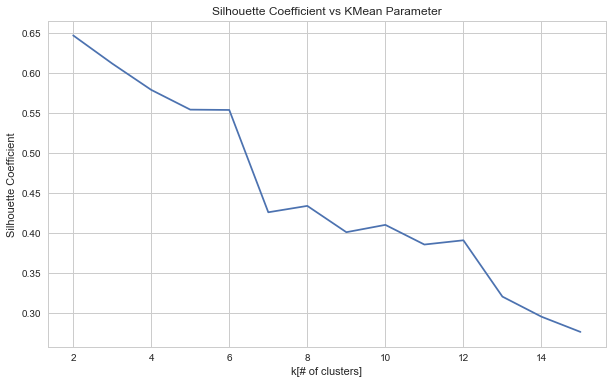

In [512]:
# plot silhouette vs cluster size 
fig, ax = plt.subplots(figsize=(10,6))

# plot silhouette_scores
plt.plot(np.arange(2, clusters+1), silhouette_scores)

# set label
plt.ylabel('Silhouette Coefficient')
plt.xlabel('k[# of clusters]')
plt.title('Silhouette Coefficient vs KMean Parameter')

# save
plt.savefig('../reports/figures/kmeans_silhouette_coefficient.png')

plt.show()

Silhouette scores near 1 show that smaples are far away from neighboring clusters.  Inspecting the plot above, we are looking for values of k that maximize the Silhouette Coefficient.  

Silhouette scores appear to decrease signifcantly once k > 4.  It's clear that smaller values of k produce a higher silhouette coefficient. 

### Calinski-Harabaz Score Results

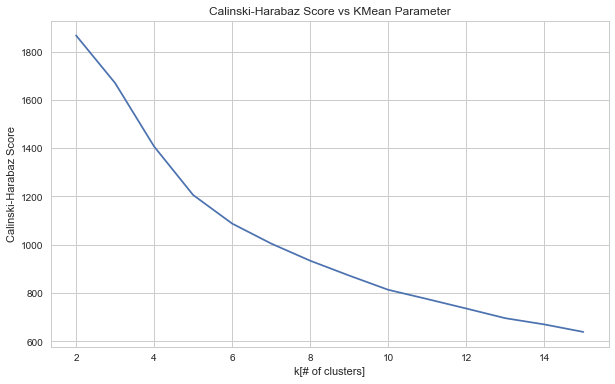

In [513]:
# plot calinski score vs cluster size
fig, ax = plt.subplots(figsize=(10,6))

# plot calinski_score
plt.plot(np.arange(2, clusters+1), calinski_score)

# set label
plt.ylabel('Calinski-Harabaz Score')
plt.xlabel('k[# of clusters]')
plt.title('Calinski-Harabaz Score vs KMean Parameter')

# save
plt.savefig('../reports/figures/kmeans_calinski_harabaz_score.png')

plt.show()

A high Calinski-Harabaz score represents dense, well separated clusters.  Based on the above graph, we are likely to select k = 2, 3, or even 4.  

Combining all performance metrics together, we are likely to select a value of k = 2 or k = 3.  Our best fit appears to be k = 3 as our clusters have a lower inertia than k=2; meaning our clusters are more compact and exhibit less variability in k=3.

### KMeans Clustering Results
We will build a final model where k=3 and see what our clusters can tell us about product data.

In [486]:
kmeans_model = KMeans(n_clusters=3, init='k-means++', random_state=42).fit(ph_crosstab_t)
c_pred = kmeans_model.predict(ph_crosstab_t)

# print our the number of observations per cluster
for c in np.unique(c_pred):
        print('cluster {}: {}'.format(c, np.sum(c_pred==c)))

cluster 0: 13430
cluster 1: 134
cluster 2: 1436


In [536]:
# add the predicticed cluster to our original dataframe
kmeans_cust = ph_crosstab.copy()
kmeans_cust['cluster'] = c_pred

With the predictions attached to our original dataframe, gather the top 12 aisles for each cluster.

In [537]:
top_aisles = set()

# get top 12 aisles for each cluster & add aisle name to top_aisles
for c in np.unique(c_pred):
    for a in kmeans_cust[kmeans_cust.cluster==c].mean().sort_values(ascending=False)[:12].index.values:
        top_aisles.add(a)


cols = list(top_aisles)
aisle_summary = pd.DataFrame(columns=top_aisles)

# create a new dataframe with the top aisles
for c in np.unique(c_pred):
    
    # get the mean value for each aisle across all customers
    cluster_values = dict(list(zip(cols, kmeans_cust[kmeans_cust.cluster==c][cols].mean().values)))

    temp=pd.DataFrame(cluster_values, index=[c])

    # add the cluster values to our dataframe
    aisle_summary = pd.concat([aisle_summary, temp], axis=0)
    

In [538]:
aisle_summary

,baby food formula,bread,chips pretzels,energy granola bars,fresh fruits,fresh vegetables,frozen produce,milk,packaged cheese,packaged vegetables fruits,refrigerated,soy lactosefree,water seltzer sparkling water,yogurt
0,0.742740,1.827774,2.177364,1.081832,11.839613,11.850410,1.753537,2.737156,3.090544,5.881534,1.795309,2.050856,2.84341,4.395309
1,99.052239,13.791045,12.992537,10.917910,83.843284,63.402985,11.492537,22.037313,24.111940,36.089552,9.544776,13.813433,13.41791,31.768657
2,3.831476,11.237465,15.514624,12.737465,67.603064,58.347493,8.787604,17.296657,18.999304,31.282033,11.258357,12.258357,14.94429,29.483287


#### Cluster 0

In [490]:
aisle_summary.iloc[0].sort_values(ascending=False)

fresh vegetables                 11.850410
fresh fruits                     11.839613
packaged vegetables fruits        5.881534
yogurt                            4.395309
packaged cheese                   3.090544
water seltzer sparkling water     2.843410
milk                              2.737156
chips pretzels                    2.177364
soy lactosefree                   2.050856
bread                             1.827774
refrigerated                      1.795309
frozen produce                    1.753537
energy granola bars               1.081832
baby food formula                 0.742740
Name: 0, dtype: float64

Cluster 0 is characterized by customer who purchase less frequently than customers in cluster 1&2.  The entire cluster has a much lower purchase mean in each aisle, however still focus on fresh fruits & vegetables.  They are also more likely to purcahse prodcuts from the bread, frozen produce & refrigerated aisle than cluster 0. 


#### Cluster 1

In [493]:
aisle_summary.iloc[1].sort_values(ascending=False)

baby food formula                99.052239
fresh fruits                     83.843284
fresh vegetables                 63.402985
packaged vegetables fruits       36.089552
yogurt                           31.768657
packaged cheese                  24.111940
milk                             22.037313
soy lactosefree                  13.813433
bread                            13.791045
water seltzer sparkling water    13.417910
chips pretzels                   12.992537
frozen produce                   11.492537
energy granola bars              10.917910
refrigerated                      9.544776
Name: 1, dtype: float64

Cluster 1 is characterized by customers purchasing baby food formula, fresh fruits, and fresh vegetables.  They are more frequent shoppers like those found in cluster 0. 

#### Cluster 2

In [494]:
aisle_summary.iloc[2].sort_values(ascending=False)

fresh fruits                     67.603064
fresh vegetables                 58.347493
packaged vegetables fruits       31.282033
yogurt                           29.483287
packaged cheese                  18.999304
milk                             17.296657
chips pretzels                   15.514624
water seltzer sparkling water    14.944290
energy granola bars              12.737465
soy lactosefree                  12.258357
refrigerated                     11.258357
bread                            11.237465
frozen produce                    8.787604
baby food formula                 3.831476
Name: 2, dtype: float64

Cluster 2 is characterized by frequent customers that purchase from the fresh fruits and vegetables aisles, followed then by products from packaged vegetables/fruits and yogurt aisles. 

### KMeans Clustering Predictions
Taking our holdout dataset, where do our new customers fall into the predicted clusters? 

In [564]:
# scale the dataset
ph_crosstab_test_scaled = rs.transform(ph_crosstab_test)

# transform our dataset into the PCA space
ph_crosstab_test_t = pca.transform(ph_crosstab_test_scaled)

In [565]:
# Predict the clusters
kmeans_cust_test = ph_crosstab_test.copy()
kmeans_cust_test['cluster'] = kmeans_model.predict(ph_crosstab_test_t)

In [566]:
top_aisle_cols = list(top_aisles)
top_aisle_cols.append('cluster')

kmeans_cust_test[top_aisle_cols]

aisle,fresh fruits,water seltzer sparkling water,fresh vegetables,soy lactosefree,refrigerated,packaged cheese,packaged vegetables fruits,yogurt,energy granola bars,chips pretzels,bread,baby food formula,frozen produce,milk,cluster
user_id,,,,,,,,,,,,,,,
206138,33,0,2,0,0,2,2,0,0,1,1,0,11,12,0
206171,0,6,0,1,0,4,0,0,0,0,0,0,0,0,0
206195,6,0,3,0,0,3,4,1,0,0,0,0,1,3,0
206199,10,5,14,0,6,13,3,48,4,18,6,3,0,5,2
206204,3,0,6,2,0,1,4,2,0,0,0,0,1,1,0


As we can see by the aisle summary above, users placed into cluster 0 are characterized by small purchase smounts in the fresh fruits & fresh vegetable aisles.  The user placed into cluser 2  is characterized by larger purchases within fresh fruits & fresh vegetables aisles.  None of the users purchase primarily baby food formula, which is why none are placed into cluster 1.

## DBSCAN Clustering
Our next clustering algorithm uses DBSCAN.  Before we begin, we need to predict two DBSCAN parameters: eps and min_smaples.  These parameters can be selected by looking at the distance to the i-th nearest neighbor, as discussed in the original DBSCAN paper by Martin Ester https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf

In [118]:
from scipy.spatial.distance import pdist, cdist, squareform

In [515]:
def kDist(data, k):
    '''
        Returns the distance between a point and it's k-th negihbors
        
        Parameters
        ----------
        data: the data used for predictions
        
        k: The number of points to find distance 
    '''
    nData = data.shape[0]
    pDistMat = squareform(pdist(data))
    kDistArray = [ sorted(pDistMat[i,:])[k-1] for i in range(nData)]

    return sorted(kDistArray, reverse=True)

We are going to calculate the distance along various values of 'k'.  Plotting the result to determine the appropriate eps value.  Ester states that k=4 provided decent results in the majority of cases.  We will plot k=4 with value above and below for good measure.

In [ ]:
# calculate kdist for various values
kDistArray_2 = kDist(ph_crosstab_t, 2)
kDistArray_3 = kDist(ph_crosstab_t, 3)
kDistArray_4 = kDist(ph_crosstab_t, 4)
kDistArray_6 = kDist(ph_crosstab_t, 6)
kDistArray_8 = kDist(ph_crosstab_t, 8)
kDistArray_10 = kDist(ph_crosstab_t, 10)

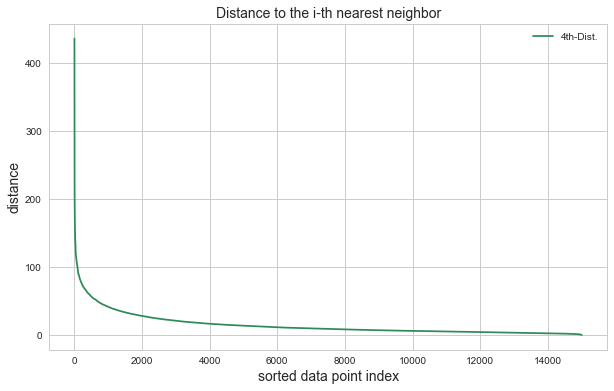

In [525]:
fig = plt.figure(figsize=(10,6))

# plot various values of k
plt.plot(range(ph_crosstab_t.shape[0]), kDistArray_4, color='seagreen', label='4th-Dist.')
#plt.plot(range(ph_crosstab_t.shape[0]), kDistArray_6, color='lightblue', label='6th-Dist.')
#plt.plot(range(ph_crosstab_t.shape[0]), kDistArray_8, color='lightblue', label='8th-Dist.')
#plt.plot(range(ph_crosstab_t.shape[0]), kDistArray_10, color='lightblue', label='10th-Dist.')

plt.xlabel('sorted data point index', size=14)
plt.ylabel('distance', size=14)
plt.title('Distance to the i-th nearest neighbor', size=14)
plt.legend()

fig.savefig('../reports/figures/dbscan_eps_estimator.png')

plt.show()

At such a zoomed out scale, it is hard to accurately select a value of eps.  We can zoom into the first segement of the graph to identify the first area that the plot begins to bend.  This allows us to select an appropriate value for further testing. 

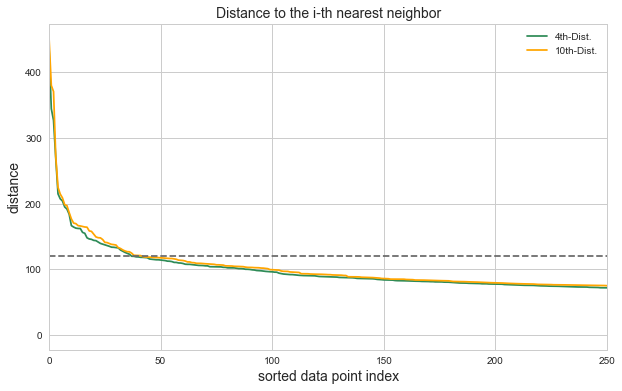

In [526]:
fig = plt.figure(figsize=(10,6))

# plot various values of k
plt.plot(range(ph_crosstab_t.shape[0]), kDistArray_4, color='seagreen', label='4th-Dist.')
plt.plot(range(ph_crosstab_t.shape[0]), kDistArray_10, color='orange', label='10th-Dist.')

plt.xlim([0,250])
plt.xlabel('sorted data point index', size=14)
plt.ylabel('distance', size=14)
plt.title('Distance to the i-th nearest neighbor', size=14)
plt.legend()

kDistLim = 120
plt.axhline(kDistLim, linestyle='--', c='dimgray')

fig.savefig('../reports/figures/dbscan_eps_estimator_zoom.png')

plt.show()

We find an elbow value at about 120 that we decide to use for our value of EPS.  Since the value is based on the 4th-nearest neighbor, we will use 4 as our starting min_samples.

With the initial values selected, we can perform some fine tuning of the algorithm.  We want to minimize the number of noise points and aim for a cluster size of 3 (as we found using Kmeans).  

In [ ]:
# create a dataframe for holding our results
dbscan_results = pd.DataFrame(columns=['eps', 'min_samples', 'clusters', 'noise_pts'])

# create values for testing eps & min samples
eps_ = [60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 
        80, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99 100, 
        105, 110, 115, 120, 125, 126, 127, 128, 129, 130]
min_samples_ = [2, 3, 4, 5, 10]

for e in eps_:
    for m in min_samples_:
        db = DBSCAN(eps=e, min_samples=m).fit(ph_crosstab_t)

        print('eps: {}, min_samples: {}, clusters: {}, noise: {}'.format(e, m, len([i for i in np.unique(db.labels_) if i != -1]), np.sum(db.labels_ < 0)))
        
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_pts = len([1 for i in labels if i == -1])

        df_pt = pd.DataFrame({'eps':[e],
                             'min_samples':[m],
                             'clusters':[n_clusters],
                             'noise_pts': [noise_pts]})

        dbscan_results = pd.concat([dbscan_results, df_pt],axis=0)        

Let's take a look at the results -  We want to find an eps value that minimizes noise points for these cluster sizes.  Based on the results in the above window we see that the algorithm works best where min_samples =2.

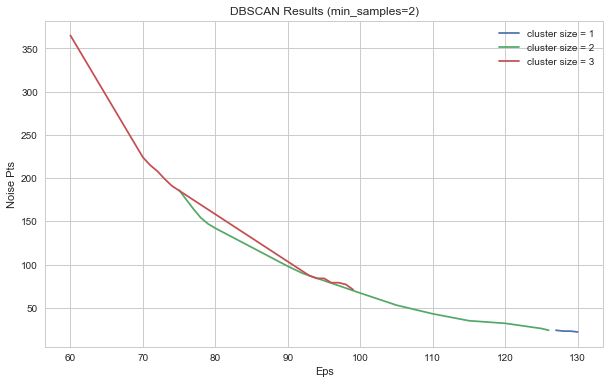

In [549]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot value for cluster size = 1
x = dbscan_results[(dbscan_results.clusters==1) & (dbscan_results.min_samples==2)].sort_values('eps').eps.values
y = dbscan_results[(dbscan_results.clusters==1) & (dbscan_results.min_samples==2)].sort_values('eps').noise_pts.values
plt.plot(x, y, label='cluster size = 1')

# plot value for cluster size = 2
x = dbscan_results[(dbscan_results.clusters==2)].sort_values('eps').eps.values
y = dbscan_results[(dbscan_results.clusters==2)].sort_values('eps').noise_pts.values
plt.plot(x, y, label='cluster size = 2')

# plot value for cluster size = 3
x = dbscan_results[(dbscan_results.clusters==3)].sort_values('eps').eps.values
y = dbscan_results[(dbscan_results.clusters==3)].sort_values('eps').noise_pts.values
plt.plot(x, y, label='cluster size = 3')

# set labels
plt.title('DBSCAN Results (min_samples=2)')
plt.xlabel('Eps')
plt.ylabel('Noise Pts')
plt.legend()

fig.savefig('../reports/figures/dbscan_eps_tuning.png')

plt.show()

It appears that cluster sizes 1 & 2 perform similarly with regards to noise points.  If we aim to select a same cluster size as Kmeans has produced, we will select a cluster size = 3.  We can find these parameters by selecting the row where clusters = 3 with the least noise

In [534]:
# Find results for clusters == 3
min_noise_pts = dbscan_results[(dbscan_results.clusters==3)].noise_pts.min()
dbscan_results[(dbscan_results.clusters==3) & (dbscan_results.noise_pts == min_noise_pts)]

,clusters,eps,min_samples,noise_pts
0,3,99,2,71


With the parameters identified, we can create our final model and begin to examine cluster results. 

### DBSCAN Clustering Results
We create a DBSCAN model where eps=99 & min_samples=2.

In [588]:
db_model = DBSCAN(eps=99, min_samples=2).fit(ph_crosstab_t)

In [568]:
dbscan_cust = ph_crosstab.copy()
dbscan_cust['cluster'] = db_model.labels_

With the clusters predicted, let's examine the purchasing habits of our 3 clusters.  We will mimic the process performed for Kmean - identifying the top 12 aisle for each cluster, before creating a new data frame with the mean values for each cluster.

In [618]:
top_aisles = set()

# get top 12 aisles for each cluster & add aisle name to top_aisles
for c in np.unique(db_model.labels_):
    for a in dbscan_cust[dbscan_cust.cluster==c].mean().sort_values(ascending=False)[:12].index.values:
        top_aisles.add(a)


cols = list(top_aisles)
aisle_summary = pd.DataFrame(columns=top_aisles)

# create a new dataframe with the top aisles
for c in np.unique(db_model.labels_):
    
    # get the mean value for each aisle across all customers
    cluster_values = dict(list(zip(cols, dbscan_cust[dbscan_cust.cluster==c][cols].mean().values)))

    temp=pd.DataFrame(cluster_values, index=[c])

    # add the cluster values to our dataframe
    aisle_summary = pd.concat([aisle_summary, temp], axis=0)
    

In [620]:
aisle_summary[aisle_summary.index >= 0]

,baby food formula,bread,canned jarred vegetables,cat food care,cereal,chips pretzels,crackers,energy granola bars,fresh fruits,fresh vegetables,frozen produce,juice nectars,milk,packaged cheese,packaged vegetables fruits,refrigerated,soft drinks,soy lactosefree,water seltzer sparkling water,yogurt
0,1.791131,2.737272,1.456123,0.245311,1.734258,3.400188,2.131498,2.049705,17.272441,16.466707,2.441184,1.575831,4.171557,4.649317,8.357248,2.645364,1.700697,3.026661,3.981310,6.685356
1,93.333333,49.000000,11.333333,18.666667,23.000000,17.666667,6.333333,86.333333,196.000000,109.000000,19.333333,8.333333,46.000000,26.000000,61.000000,17.333333,50.333333,6.333333,3.666667,18.000000
2,347.500000,11.000000,17.000000,0.000000,25.000000,1.500000,2.000000,0.000000,103.000000,84.500000,18.000000,16.000000,39.500000,38.500000,53.000000,3.500000,10.500000,3.500000,17.000000,35.500000


#### Cluster 0

In [584]:
aisle_summary.iloc[0].sort_values(ascending=False)

fresh fruits                     17.272441
fresh vegetables                 16.466707
packaged vegetables fruits        8.357248
yogurt                            6.685356
packaged cheese                   4.649317
milk                              4.171557
water seltzer sparkling water     3.981310
chips pretzels                    3.400188
soy lactosefree                   3.026661
bread                             2.737272
refrigerated                      2.645364
frozen produce                    2.441184
energy granola bars               2.049705
baby food formula                 1.791131
cereal                            1.734258
soft drinks                       1.700697
juice nectars                     1.575831
canned jarred vegetables          1.456123
cat food care                     0.245311
Name: 0, dtype: float64

Cluster 0 is characterized by infrequent customers who primarily purchase fresh fruits & fresh vegetables.  They are also less likely to purchase baby food formula & cat food. 

#### Cluster 1

In [585]:
aisle_summary.iloc[1].sort_values(ascending=False)

fresh fruits                     196.000000
fresh vegetables                 109.000000
baby food formula                 93.333333
energy granola bars               86.333333
packaged vegetables fruits        61.000000
soft drinks                       50.333333
bread                             49.000000
milk                              46.000000
packaged cheese                   26.000000
cereal                            23.000000
frozen produce                    19.333333
cat food care                     18.666667
yogurt                            18.000000
chips pretzels                    17.666667
refrigerated                      17.333333
canned jarred vegetables          11.333333
juice nectars                      8.333333
soy lactosefree                    6.333333
water seltzer sparkling water      3.666667
Name: 1, dtype: float64

Cluster 1 appears to be frequent shoppers that primarily purchase fresh fruits & vegetables.  They are also likely to purchase baby food formula and energy granola bars.  

They are also more likely to buy cat food than yogurt. 

#### Cluster 2

In [587]:
aisle_summary.iloc[2].sort_values(ascending=False)

baby food formula                347.5
fresh fruits                     103.0
fresh vegetables                  84.5
packaged vegetables fruits        53.0
milk                              39.5
packaged cheese                   38.5
yogurt                            35.5
cereal                            25.0
frozen produce                    18.0
water seltzer sparkling water     17.0
canned jarred vegetables          17.0
juice nectars                     16.0
bread                             11.0
soft drinks                       10.5
refrigerated                       3.5
soy lactosefree                    3.5
chips pretzels                     1.5
energy granola bars                0.0
cat food care                      0.0
Name: 2, dtype: float64

Cluster 2 is similar to a cluster we found in Kmeans - that is customers who purchase primarily Baby food formula, followed by fresh fruits & vegetables. 

### DBSCAN Clustering Predictions
Taking our holdout dataset, where do our new customers fall into the predicted clusters? DBSCAN does not offer a predict method - rather, we will need to build a classifier based on our known values and predict the labels for the unclassified customers.

In [600]:
from sklearn.linear_model import LogisticRegression

In [601]:
# create the classifier
clf = LogisticRegression()

# The x values will simply be the scaled & PCA transformed dataset.
X = ph_crosstab_t

# The y values will by the predicted labels
y = db_model.labels_

# We can scale & transform our test dataset using the previously declared scaler & pca
X_test = pca.transform(rs.transform(ph_crosstab_test))

# predict
clf.fit(X, y)
c_pred = clf.predict(X_test_t)


In [603]:
# Predict the clusters
dbscan_cust_test = ph_crosstab_test.copy()
dbscan_cust_test['cluster'] = c_pred

In [604]:
# lets see the top aisles for our test dataset
top_aisle_cols = list(top_aisles)
top_aisle_cols.append('cluster')

dbscan_cust_test[top_aisle_cols]

aisle,fresh fruits,canned jarred vegetables,water seltzer sparkling water,fresh vegetables,soy lactosefree,refrigerated,packaged cheese,juice nectars,cereal,packaged vegetables fruits,yogurt,energy granola bars,chips pretzels,cat food care,bread,baby food formula,frozen produce,soft drinks,milk,cluster
user_id,,,,,,,,,,,,,,,,,,,,
206138,33,0,0,2,0,0,2,2,2,2,0,0,1,0,1,0,11,0,12,0
206171,0,0,6,0,1,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0
206195,6,7,0,3,0,0,3,1,0,4,1,0,0,0,0,0,1,2,3,0
206199,10,0,5,14,0,6,13,3,12,3,48,4,18,0,6,3,0,12,5,0
206204,3,0,0,6,2,0,1,0,0,4,2,0,0,1,0,0,1,0,1,0


I'm surprised that all customers were placed into cluster 0 - specifically user # 4.  Looking closer at the data we can justify these classifications based on how they do not belong in cluster 1 or 2.  That is:
* Users do not buy baby food formula more frequently than fresh fruits, fresh vegetables, packaged vegetables/fruits or yogurt
* Users do not primarily buy cat food


## Hierarchical Clustering
We will look at utilizing Agglomerative Clustering for our final algorithm.  Similarily to Kmeans, we will be selecting a cluster size based on silhouette and calinski-harabaz scores. I've created a function hierarchical_performance_metrics below that calculates these scores for a given dataset and cluster size. 

With Agglomerative Clustering, we also have the ability to look at different linkage & affinity variables.  Both are setup to be tested in the performance metric function.

In [276]:
def hierarchical_performance_metrics(data, clusters):
    '''
        Compute Agglomerative Clustering for various cluster values, ranging from 
        2 to k+1.  Caclucate the silhouette score and calinkski-harabaz
        score for each value, returning the results.
        
        Params
        ------
        data: The dataset to perform clustering upon
        
        clusters: The number of cluster to create
    '''
    
    # create a dataframe to hold our results
    df_results = pd.DataFrame(columns=['n_clusters', 'linkage', 'affinity', 'score_type', 'score'])

    # define parameters
    linkage = ['complete', 'average']
    affinity = ['euclidean', 'cosine']

    # Process each range
    for c in range(2, clusters+1):
        print('processing n_clusters={}, linkage=ward, affinity=euclidean'.format(c))
        
        # build model using ward linkage
        model = AgglomerativeClustering(n_clusters=c, linkage='ward').fit(data)

        # add score
        result = pd.DataFrame({'n_clusters':[c], 'linkage': ['ward'], 'affinity': ['euclidean'],'score_type': ['silhouette'], 'score': [silhouette_score(data, model.labels_)]})

        df_results = pd.concat([df_results, result], axis=0)

        # add score
        result = pd.DataFrame({'n_clusters':[c],'linkage': ['ward'],'affinity': ['euclidean'],'score_type': ['calinski harabaz'],'score': [calinski_harabaz_score(data, model.labels_)]})

        df_results = pd.concat([df_results, result], axis=0)

        # process other linkages
        for l in linkage:
            for a in affinity:
                print('processing n_clusters={}, linkage={}, affinity={}'.format(c, l, a))

                # build model
                model = AgglomerativeClustering(n_clusters=c, linkage=l, affinity=a).fit(data)

                # add score
                result = pd.DataFrame({'n_clusters':[c], 'linkage': [l], 'affinity': [a],'score_type': ['silhouette'], 'score': [silhouette_score(data, model.labels_)]})

                df_results = pd.concat([df_results, result], axis=0)

                # add score
                result = pd.DataFrame({'n_clusters':[c],'linkage': [l],'affinity': [a],'score_type': ['calinski harabaz'],'score': [calinski_harabaz_score(data, model.labels_)]})

                df_results = pd.concat([df_results, result], axis=0)

    
    return df_results

Calculate metrics for our dataset using cluster size up to 15.

In [277]:
hpm = hierarchical_performance_metrics(ph_crosstab_t, 15)

processing n_clusters=2, linkage=ward, affinity=euclidean
processing n_clusters=2, linkage=complete, affinity=euclidean
processing n_clusters=2, linkage=complete, affinity=cosine
processing n_clusters=2, linkage=average, affinity=euclidean
processing n_clusters=2, linkage=average, affinity=cosine
processing n_clusters=3, linkage=ward, affinity=euclidean
processing n_clusters=3, linkage=complete, affinity=euclidean
processing n_clusters=3, linkage=complete, affinity=cosine
processing n_clusters=3, linkage=average, affinity=euclidean
processing n_clusters=3, linkage=average, affinity=cosine
processing n_clusters=4, linkage=ward, affinity=euclidean
processing n_clusters=4, linkage=complete, affinity=euclidean
processing n_clusters=4, linkage=complete, affinity=cosine
processing n_clusters=4, linkage=average, affinity=euclidean
processing n_clusters=4, linkage=average, affinity=cosine
processing n_clusters=5, linkage=ward, affinity=euclidean
processing n_clusters=5, linkage=complete, affin

With the metrics calculated, let's graph them to visually inspect our results

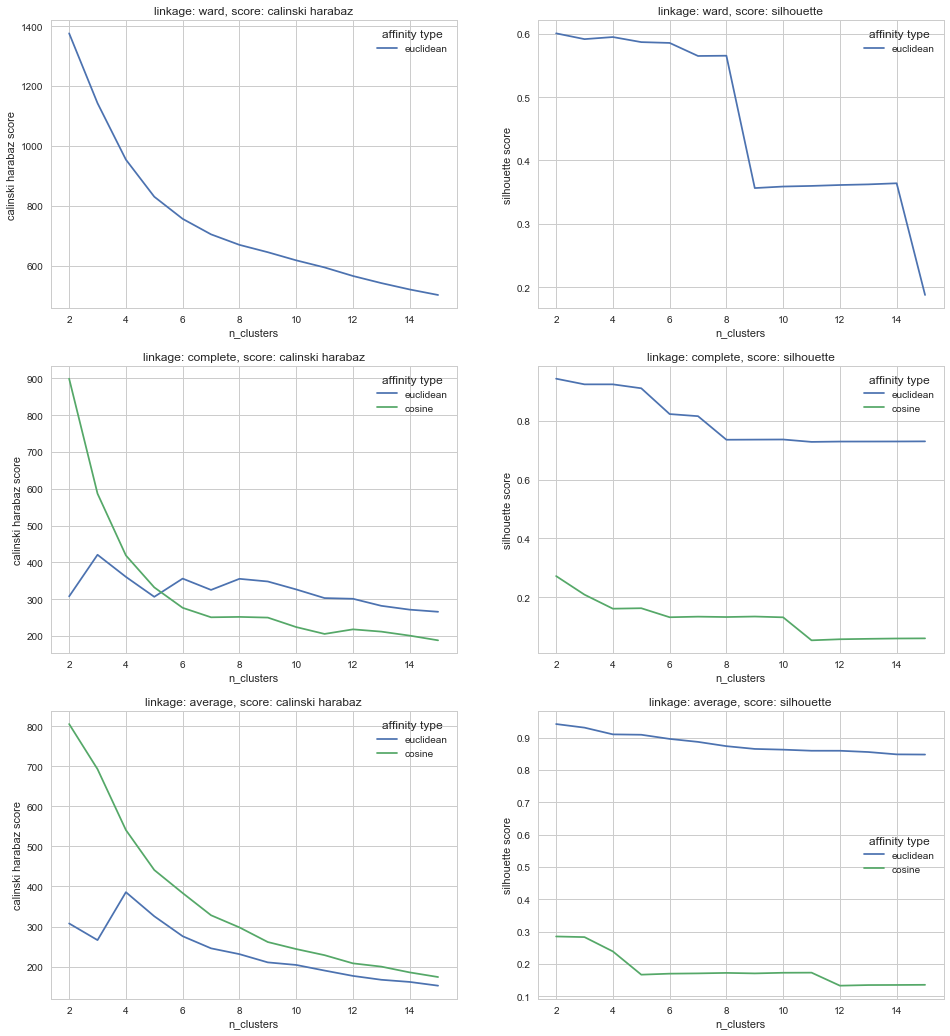

In [606]:
# define number of subplots & columns
total_subplots = 6
total_cols = 2

# determine the number of rows required
total_rows = total_subplots // total_cols
total_rows += total_subplots % total_cols

# setup subplot position
pos = range(1, total_subplots+1)

# create plot
fig = plt.figure(figsize=(16,18))
i=0

# define linkage and affinity options
linkage = ['ward', 'complete', 'average']
affinity = ['euclidean', 'cosine']

# loop through each linkage type
for l in linkage:
    
    # loop through each score type
    for s in np.unique(hpm[(hpm.linkage==l)].score_type):

        ax = fig.add_subplot(total_rows, total_cols, pos[i])
        ax.set_title('linkage: {}, score: {}'.format(l, s))
        ax.set_xlabel('n_clusters')
        ax.set_ylabel('{} score'.format(s))

        # loop through each affinity type
        for a in np.sort(np.unique(hpm[(hpm.linkage==l) & (hpm.score_type==s)].affinity))[::-1]:

            # create plot
            x = hpm[(hpm.linkage==l) & (hpm.score_type==s) & (hpm.affinity==a)].n_clusters
            y = hpm[(hpm.linkage==l) & (hpm.score_type==s) & (hpm.affinity==a)].score
            ax.plot(x, y, label=a)
            
        ax.legend(title='affinity type')
        i+=1

fig.savefig('../reports/figures/ac_tuning.png')
    
plt.show()

We will look for a value that optimizes where k=3 so that we can be consistent with our other two clustering algorithms.  Using linkage = complete or average apperas to maximize our silhouette scores, where as linkage = ward maximizes the calinski harabaz score.

For our purposes, It appears that the optimal parameters are:
* linkage = complete
* n_clusters = 3
* affinity = euclidean

These values appear to have the best overall calinski harabaz & silhouette scores.  It does appear that using linkage = average, n_clusters = 4, and affinity = euclidean provides very suitable results as well.

### Hierarchical Clustering Results
We create a DBSCAN model where n_clusters=3, linkage=complete, affinity=euclidean

In [615]:
# build the model
ac_model = AgglomerativeClustering(n_clusters=3, linkage='complete', affinity='euclidean').fit(ph_crosstab_t)

In [611]:
# build the model
ac_model = AgglomerativeClustering(n_clusters=4, linkage='average', affinity='euclidean').fit(ph_crosstab_t)

In [ ]:
# build the model
ac_model = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(ph_crosstab_t)

In [621]:
ac_cust = ph_crosstab.copy()
ac_cust['cluster'] = ac_model.labels_

In [622]:
top_aisles = set()

# get top 12 aisles for each cluster & add aisle name to top_aisles
for c in np.unique(ac_model.labels_):
    for a in ac_cust[ac_cust.cluster==c].mean().sort_values(ascending=False)[:12].index.values:
        top_aisles.add(a)


cols = list(top_aisles)
aisle_summary = pd.DataFrame(columns=top_aisles)

# create a new dataframe with the top aisles
for c in np.unique(ac_model.labels_):
    
    # get the mean value for each aisle across all customers
    cluster_values = dict(list(zip(cols, ac_cust[ac_cust.cluster==c][cols].mean().values)))

    temp=pd.DataFrame(cluster_values, index=[c])

    # add the cluster values to our dataframe
    aisle_summary = pd.concat([aisle_summary, temp], axis=0)
    

In [623]:
aisle_summary

,baby food formula,bread,breakfast bars pastries,candy chocolate,cereal,chips pretzels,coffee,energy granola bars,fresh dips tapenades,fresh fruits,...,frozen produce,juice nectars,milk,packaged cheese,packaged vegetables fruits,poultry counter,refrigerated,soy lactosefree,water seltzer sparkling water,yogurt
0,1.848683,2.82921,0.336579,1.492231,1.829276,3.545715,0.969990,2.235545,1.670824,17.786529,...,2.503701,1.645082,4.29023,4.792798,8.570257,0.635278,2.757586,3.128376,4.086629,7.032211
1,343.000000,36.00000,0.000000,5.333333,55.333333,13.666667,0.333333,0.000000,0.333333,136.666667,...,55.000000,10.666667,44.00000,43.666667,72.000000,37.333333,2.333333,23.000000,15.666667,24.000000
2,0.000000,0.00000,46.000000,27.500000,0.000000,26.500000,25.000000,380.500000,30.000000,100.000000,...,0.500000,31.500000,43.50000,10.500000,9.500000,0.000000,100.000000,9.000000,59.500000,52.000000


#### Cluster 0

In [625]:
aisle_summary.iloc[0].sort_values(ascending=False)

fresh fruits                     17.786529
fresh vegetables                 16.747449
packaged vegetables fruits        8.570257
yogurt                            7.032211
packaged cheese                   4.792798
milk                              4.290230
water seltzer sparkling water     4.086629
chips pretzels                    3.545715
soy lactosefree                   3.128376
bread                             2.829210
refrigerated                      2.757586
frozen produce                    2.503701
energy granola bars               2.235545
baby food formula                 1.848683
cereal                            1.829276
fresh dips tapenades              1.670824
juice nectars                     1.645082
candy chocolate                   1.492231
coffee                            0.969990
poultry counter                   0.635278
breakfast bars pastries           0.336579
frozen breads doughs              0.197599
Name: 0, dtype: float64

#### Cluster 1

In [626]:
aisle_summary.iloc[1].sort_values(ascending=False)

baby food formula                343.000000
fresh fruits                     136.666667
fresh vegetables                 101.333333
packaged vegetables fruits        72.000000
cereal                            55.333333
frozen produce                    55.000000
milk                              44.000000
packaged cheese                   43.666667
poultry counter                   37.333333
bread                             36.000000
frozen breads doughs              25.000000
yogurt                            24.000000
soy lactosefree                   23.000000
water seltzer sparkling water     15.666667
chips pretzels                    13.666667
juice nectars                     10.666667
candy chocolate                    5.333333
refrigerated                       2.333333
fresh dips tapenades               0.333333
coffee                             0.333333
energy granola bars                0.000000
breakfast bars pastries            0.000000
Name: 1, dtype: float64

#### Cluster 2

In [627]:
aisle_summary.iloc[2].sort_values(ascending=False)

energy granola bars              380.5
refrigerated                     100.0
fresh fruits                     100.0
water seltzer sparkling water     59.5
yogurt                            52.0
breakfast bars pastries           46.0
milk                              43.5
juice nectars                     31.5
fresh dips tapenades              30.0
candy chocolate                   27.5
chips pretzels                    26.5
coffee                            25.0
packaged cheese                   10.5
packaged vegetables fruits         9.5
soy lactosefree                    9.0
fresh vegetables                   1.0
frozen produce                     0.5
frozen breads doughs               0.0
cereal                             0.0
poultry counter                    0.0
bread                              0.0
baby food formula                  0.0
Name: 2, dtype: float64

### DBSCAN Clustering Predictions
